# LIGN 168 Final Project


In [2]:
import numpy as np
import librosa
from librosa.feature import mfcc
import os
import random
import shutil
from hmmlearn import hmm
import IPython.display as ipd


## Part 1 Introduction and Background of HMM Architecture

### 1.1 The Goals Of This Project

### 1.2 Terminology used in this project

The following will include a few terminologies that is going to be frequently mentioned in the project. Their definitions were taken form this [Youtube](https://www.youtube.com/watch?v=i3AkTO9HLXo&list=PLM8wYQRetTxBkdvBtz-gw8b9lcVkdXQKV) playlist here by Normalized Nerd
#### 1.2.1 Hidden States

Hidden states in a Hidden Markov Model (HMM) represent the underlying, unobservable processes that influence the generation of observable data. These states are crucial for capturing the dependencies and temporal structure in sequential data, even though they cannot be directly observed. By using algorithms like the Viterbi algorithm, we can infer the most likely sequence of hidden states based on the observed data, allowing us to understand the hidden dynamics of the system.




#### 1.2.2 Obervable States

Observable states are the directly measurable outputs influenced by the underlying hidden states. These observations are used to infer the hidden states and understand the probabilistic relationships within the model. The emission probabilities define the likelihood of observing a particular observable state given a specific hidden state, bridging the gap between the hidden dynamics and the observed data

#### 1.2.4 Inference algorithms
Inference algorithms are used to figure out the parameters required to finetune the hmm model to maximize its accuracy -- mainly because they are highly varied depending on the applications: For example, Viterbi algorithm or the Forward-Backward algorithm, are used to estimate the most likely sequence of Hidden States given a sequence of Observable States, or the Baulm-Watch algorithm, used to determine the optimal amount of iteration required for the model converge at a certain point.


## 1.3 MFCCs

### 1.3.1 MFCC
As covered in lectures, Mel Frequency Cepstral Co-efficients are one of the ways we can make speech recognition systems mimick human hearing -- represent speech signals on a Mel scale instead of Hertz, which does a better job at capturing perceptually relevant features:

While the lectures cover a few of the main processes involves, I have compilated a more comprehensive steps from the [research article](https://iosrjen.org/Papers/vol4_issue8%20(part-1)/D04812125.pdf) by Singh and Rani (2014)

1. Pre-emphasis: Amplifying high frequencies to balance the spectrum.
2. Framing: Dividing the signal into small frames (e.g., 25ms) to analyze short segments of the audio.
3. Windowing: Applying a window function (e.g., Hamming window) to each frame to reduce edge effects.
4. Fast Fourier Transform (FFT): Converting the time-domain signal to the frequency domain.
5. Mel Filter Bank: Applying a set of filters spaced according to the Mel scale to the power spectrum.
7. Discrete Cosine Transform (DCT): Applying DCT to decorrelate and pack the most significant information into the first few coefficients.

### 1.3.2 MFCC as Hidden States
In context of Markov Chains, MFCCs are the observation data for HMMs to make their predictions on the next phonemes. In HMMs used for speech recognition, I believe that the hidden states can correspond to phonemes, which are the basic units of sound in speech as discussed earlier. With each state represents a specific phoneme, and the transitions between states capture the likelihood of one phoneme following another. By modeling these temporal dependencies between phonemes, HMMs can effectively capture the sequential nature of speech. This allows for more accurate recognition of phoneme sequences, even in the presence of variability and noise in the speech signal.

For this project, the input speech signal is first converted into a sequence of MFCCs. An HMM then uses these observations to decode the most likely sequence of phonemes, words, or phrases being spoken. The parameters of the HMM, including transition probabilities and emission probabilities, are typically learned from a labeled dataset of speech recordings. Techniques such as the Baum-Welch algorithm are used to train these models.



## Part 2 Putting them together


### 2.1 Data and Imports
I will be using 7 folders, with each containg around 15 pronounciations of a certain fruit, taken from an existing [Hmm Speech Recognition archive data base](https://code.google.com/archive/p/hmm-speech-recognition/downloads), and then using a 20/80 split to seperate this files into testing and training data to validate the model using random and os. The below code first randomly shuffles the array containing directories to every .wav file of fruit in that category, and then partitions it at 20 and 80 percent. The 20 percent is then later joined ith the new test directory and moved over to the new ```test``` folder.

In [3]:
# Directories for the split datasets
data_dir = './audio'
test_dir = './test/'

# Function to split files
def split_files(input_dir, test_dir, split_ratio=0.2):
    """
    Allocates 20% of the files in the input_dir of each fruit into
    testing folder
    
    Args:
        input_dir (str): Location of input directory
        test_dir (str): Location of test directory
        split_ratio (float, optional): PErcentage of 
        the files from training dataset that goes to 
        testing. Defaults to 0.2.
    """
    # Randomly Shuffles the array of files
    files = os.listdir(input_dir)
    random.shuffle(files)
    
    # Figuring out where to make to partition(at 20%)
    split_index = int(len(files) * split_ratio)
    test_files = files[:split_index]

    # Making a new path in a folder by the name of the fruit
    category = os.path.basename(os.path.normpath(input_dir))
    category_test_dir = os.path.join(test_dir, category)

    # Join new test directory with the new fruit directory
    os.makedirs(category_test_dir, exist_ok=True)
    
    # Move the files over
    for file in test_files:
        shutil.move(os.path.join(input_dir, file), os.path.join(category_test_dir, file))


# Create train and test directories if they don't exist
if not os.path.exists(test_dir):
    os.makedirs(test_dir, exist_ok=True)
    # Perform the split for each category
    for input_dir in os.listdir(data_dir):
        subfolder = os.path.join(data_dir, input_dir)
        split_files(subfolder, test_dir)
    

### 2.2 Architecture(For More Details, Please refer to the self-reflection)
For the word labeler, I will be training an Hidden Markov Model for each word -- and storing it in an Array. And during the execution of word classification, the HMM object with the strongest/highest "score" is most likely to be the correct predictor of the word. We are using a Gaussian instead of a multi-nomial Hidden Markov Models because we are inputting a continous, speech data(MFCCs). 


### 2.2.1 Trainer
The below HMMTrainer class is borrowed from the [```Python Machine Learning Cookbook```](https://github.com/AzatAI/cs_books/blob/master/Machine%20Learning%20with%20Python%20Cookbook%20(en).pdf) by Prakeet Joshi and modified by Porter(2017), once again modified by me for this project:

#### 2.2.2 Figuring Out Hidden States: <br>

A good number of hidden state may provide the recognition system with more flexibility to model complex speech patterns and variations. However, using too many hidden states can lead to overfitting, where the model becomes too closely tailored to the training data and performs poorly on unseen data.  

"Fitting a model with 271 free scalar parameters with only 260 data points will result in a degenerate solution." warning message as well as an exceptionally low accuracy rate during testing rate was a indicator for overfitting

I set the default number of hidden states to be 5, corresponding to the average number of phonemes present in the each word in the current vocabulary:

Banana: /bəˈnæn.ə/ 6
Apple: /ˈæp.əl/ 4 
Pineapple: /ˈpaɪ.næp.əl/ 8
Pear: /pɛr/ 3
Kiwi: /ˈkiwi/ 4
Orange: /ˈɔr.ɪndʒ/ 5
Peach: /piʧ/ 3

33 / 7 is about 4.7, 5ish.

I understand that there are additional algorithms I can employ at the preprocessing steps such as the Virberti, or the forward backward algorithms to determine the optimal hidden states for this. However, this is a bit out of the current scope and will be something I wish to do in more technicality in the future.

In [4]:
# Gaussian Hmm because we are using inputting a continous data for speech recognition
class HMMTrainer(object):
  def __init__(self, model_name='GaussianHMM', n_components=5, n_iter = 100):
    #I have picked n_iter to be 100 after the models had some issues converging at the default iteration value of 10
    self.model_name = model_name
    self.n_components = n_components
    self.n_iter = n_iter
    self.models = []
    if self.model_name == 'GaussianHMM':
      self.model=hmm.GaussianHMM(n_components=n_components, n_iter = n_iter)
      
  def train(self, X):
     self.models.append(self.model.fit(X))
     
  def get_score(self, input_data):
       return self.model.score(input_data)

#### 2.2.3 Training
An array containing all the sets of the hmm models that are trained on their respective fruit, as well as the fruit label is created. I have picked the first 13 MFCCs to filter out partly because, as Poorjam(2018)'s [statement](https://www.researchgate.net/post/Why_we_take_only_12-13_MFCC_coefficients_in_feature_extraction) paraphrased, that there exist a need to to select the first 13 striking a balance between feature richness and computational efficiency, making it a widely adopted approach in speech processing pipelines.

The below code gets all the folder containing the recordins of the fruits and converts them into MFCCs. A category of fruit's wav files are individually converted to MFCCs, and then spliced to keep the first 13, and then fed into a single HMM model trainer. The result is an array with 7 hmm models -- 1 for each fruit

In [5]:
hmm_models = []
data_dir = "./audio"
parts = 13 
# Getting all folders containing name of each fruit
for dirname in os.listdir(data_dir):
  # Get the name of the subfolder 
  subfolder = os.path.join(data_dir, dirname)
  if not os.path.isdir(subfolder): 
    continue
  # Extract the label
  label = subfolder[subfolder.rfind('/') + 1:]
  # Initialize variables
  X = np.array([])
  y_words = []
  
  # Train a model for each fruit, and add it to the models list
  for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]:
    # Read the input file
    filepath = os.path.join(subfolder, filename)
    sampling_freq, audio = librosa.load(filepath)
    # Extract MFCC features
    mfcc_features = mfcc(y = sampling_freq, sr = audio)
    # Take 13
    mfcc_features = mfcc_features[:,:parts]
    # Append to the variable X
    if len(X) == 0:
      X = mfcc_features
    else:
      X = np.append(X, mfcc_features, axis=0)
    # Append the label
    y_words.append(label)
    hmm_trainer = HMMTrainer()
    hmm_trainer.train(X)
    hmm_models.append((hmm_trainer, label))

### 2.3 Testing

The architecture of the testing system is as follows. Two helper functions, with one testing whether if the model predicts the fruit correctly from a singular .wav file, and another helper function that incorporates the previous helper function in assessing the performance score of how the model did over each fruit in totality -- by outputing a percentage score of the prediction rate in decimals

#### 2.3.1 Tester Function for Each Sound File
This tester function is designed to assess the performance of a single fruit sound recognition system by evaluating its accuracy in classifying sound files stored in a specified directory. It gets the MFCC from the select test directory and compares it to the label of the HMM model in the trained HMM model array to retrieve the one with the highest confidence score. then it checks, and returns a boolean indicating whether if it is a match or not

In [6]:
def test(file_path):
    """
    This tester function is designed to assess the performance of a 
    single fruit sound recognition system by evaluating its accuracy 
    in classifying sound files stored in a specified directory.
    
    Parameters: 
    file_path (String): Path to the specific file
    
    Returns:
    A boolean indicate successful prediction
    
    """
    # Initialize the list to store scores   
    hmm_scores = []  
    sampling_freq, audio = librosa.load(file_path)
    # Extract MFCC features
    mfcc_features = mfcc(y = sampling_freq, sr = audio)
    # Take 13
    mfcc_features = mfcc_features[:,:13]
    # Iterate over each HMM model and its label
    for hmm_model, label in hmm_models:
        # Get the score for the current model
        hmm_score = hmm_model.get_score(mfcc_features)  
        # Append the score to the list
        hmm_scores.append(hmm_score)  
    # Find the index of the maximum score
    index = np.argmax(hmm_scores)
    # Retrieving the Label of the model with the highes score
    best_model_label = hmm_models[index][1]
    # Print the output
    print("Predicted:", best_model_label)
    print("Actual:", file_path)
    # Return true if the label matches the file_path containing the name of the fruit
    if(best_model_label.split("\\")[1] in file_path.lower()):
        return True
    else:
        return False


#### 2.3.2 Tester Function of Directory

This tester function iterates over each fruit category and calculates the success rate as the ratio of test_score to count(using input from the single test function), representing the system's accuracy for that category. This process repeats for each fruit category, providing a 
comprehensive evaluation of the recognition system's overall performance. 

In [7]:
def tester(directory_path):
    """
    This tester function iterates over each fruit category and calculates
    the success rate as the ratio of test_score to count(using input from
    the single test function), representing the system's accuracy for that
    category. This process repeats for each fruit category, providing a 
    comprehensive evaluation of the recognition system's overall performance. 
    
    Parameters:
        directory_path (string): Directory of where the testing directory 
        is lcoated
    
    """
    total_score = 0
    test_score = 0
    count = 0
    for fruit_name in os.listdir(directory_path):
    # Construct the full path to the file
        fruit_path = os.path.join(directory_path, fruit_name)
        # Check if it's a file (not a directory) before processing
        for fruit_sound in os.listdir(fruit_path):
            # Construct the full path to the file
            fruit_wav_path = os.path.join(fruit_path, fruit_sound)
            if os.path.isfile(fruit_wav_path):
                # Counts the number of Trues it got for the directory
                if test(fruit_wav_path):
                    test_score += 1
                count += 1 
                # Calculates the ratio of the test_score to the counted files
        accuracy_score = test_score/(count)
        print(str(accuracy_score) + "(Decimals) Success Rate for " + fruit_name)
        # Add to total score
        total_score += accuracy_score
        # Reset for the next directory
        test_score = 0
        count = 0
    print("Overall model score: " + str(total_score/7))
        


#### 2.3.3 Testing With Original Testing Set


In [8]:
tester("./test")

Predicted: audio\apple
Actual: ./test\apple\apple06.wav
Predicted: audio\apple
Actual: ./test\apple\apple12.wav
Predicted: audio\apple
Actual: ./test\apple\apple14.wav
1.0(Decimals) Success Rate for apple
Predicted: audio\banana
Actual: ./test\banana\banana02.wav
Predicted: audio\banana
Actual: ./test\banana\banana07.wav
Predicted: audio\banana
Actual: ./test\banana\banana08.wav
1.0(Decimals) Success Rate for banana
Predicted: audio\kiwi
Actual: ./test\kiwi\kiwi01.wav
Predicted: audio\kiwi
Actual: ./test\kiwi\kiwi02.wav
Predicted: audio\kiwi
Actual: ./test\kiwi\kiwi10.wav
1.0(Decimals) Success Rate for kiwi
Predicted: audio\lime
Actual: ./test\lime\lime02.wav
Predicted: audio\lime
Actual: ./test\lime\lime06.wav
Predicted: audio\lime
Actual: ./test\lime\lime15.wav
1.0(Decimals) Success Rate for lime
Predicted: audio\orange
Actual: ./test\orange\orange01.wav
Predicted: audio\orange
Actual: ./test\orange\orange09.wav
Predicted: audio\orange
Actual: ./test\orange\orange15.wav
1.0(Decimals)

#### Additional Testing With AI Generated Speech

I went ahead and AI generated 4 clips of audio of each fruit being pronounced in [ElevenLabs' TTS model](https://elevenlabs.io/app/speech-synthesis). The results were unsurprisingly problematic.. 35% accuracy rate.

In [9]:
tester("./AI_Test")

Predicted: audio\apple
Actual: ./AI_Test\Apple\ElevenLabs_2024-06-11T20_09_42_Adam_pre_s50_sb75_se0_b_m2.wav
Predicted: audio\apple
Actual: ./AI_Test\Apple\ElevenLabs_2024-06-11T20_09_45_Alice_pre_s50_sb75_se0_b_m2.wav
Predicted: audio\apple
Actual: ./AI_Test\Apple\ElevenLabs_2024-06-11T20_09_48_Clyde_pre_s50_sb75_se0_b_m2.wav
Predicted: audio\peach
Actual: ./AI_Test\Apple\ElevenLabs_2024-06-11T20_09_53_Emily_pre_s50_sb75_se0_b_m2.wav
0.75(Decimals) Success Rate for Apple
Predicted: audio\peach
Actual: ./AI_Test\Banana\ElevenLabs_2024-06-11T20_09_58_Emily_pre_s50_sb75_se0_b_m2.wav
Predicted: audio\peach
Actual: ./AI_Test\Banana\ElevenLabs_2024-06-11T20_10_05_Fin_pre_s50_sb75_se0_b_m2.wav
Predicted: audio\apple
Actual: ./AI_Test\Banana\ElevenLabs_2024-06-11T20_10_37_Arnold_pre_s50_sb75_se0_b_m2.wav
Predicted: audio\peach
Actual: ./AI_Test\Banana\ElevenLabs_2024-06-11T20_11_14_Freya_pre_s50_sb75_se0_b_m2.wav
0.0(Decimals) Success Rate for Banana
Predicted: audio\apple
Actual: ./AI_Test\K

#### 3. Discussion Of Results and Evaluation

The difference in accuracy rates between the original testing files and AI-generated voice files can be attributed to several factors.

100% accuracy rate vs 20-35% with a completely new voice.

As mentioned by Will, AI models can be brittle when presented with data that is different from the training data, which causes it to struggle to generalize to new or unexpected data such as AI-generated speech. This might be a few reasons:

Firstly, the original testing files likely share similar audio quality and potentially feature the same speaker as the training data, enabling the recognition system to perform well due to familiarity with speech patterns and characteristics present in the training data. Conversely, AI-generated voices may introduce variations(such as accents, ) in speech, which has not have been adequately represented in the training data. 

Another might be I maybe still overfitting or underfitting my HMM models -- it occurs when a model learns to memorize the training data instead of capturing underlying patterns or learning too little from training data that it cannot grasp a generalized pattern. This can happen if the model is too complex relative to the amount of training data. As a result, the model may perform well on the training data but struggle to generalize to new data. 




#### 3.1 Visualization of Testing Data MFCCs(AI vs Original)
I have taken 2 samples of the .wav file, each containing pronounciations for "apple" from both the original testing and new AI testing sets, and created a MFCC graph using the paramters(5 hidden states, 13 Mfccs) I previously fed into the models in an attempt visualize what the HMM model detecting as input.

Additionally, I also calculated the Frobenius Norm between the training and the AI data, as well as to their respective other recordings as to visualize the difference in two MFCC matricies

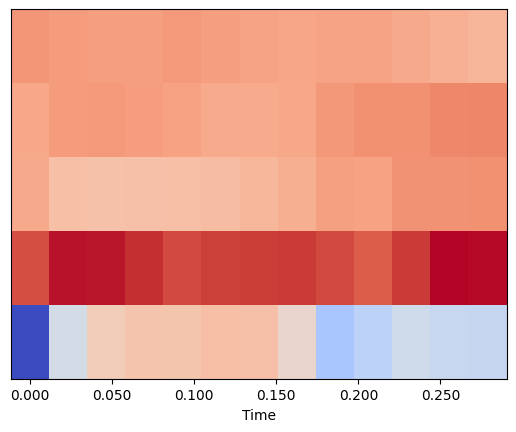

In [13]:
AI_apple_data, AI_apple_sr = librosa.load("AI_Test/Apple/ElevenLabs_2024-06-11T20_09_42_Adam_pre_s50_sb75_se0_b_m2.wav")
AI_apple_mfcc_features = mfcc(y = AI_apple_data, sr = AI_apple_sr, n_mfcc = 5)
AI_apple_mfcc_features = AI_apple_mfcc_features[:,:13]
librosa.display.specshow(AI_apple_mfcc_features, sr=AI_apple_sr, x_axis='time')

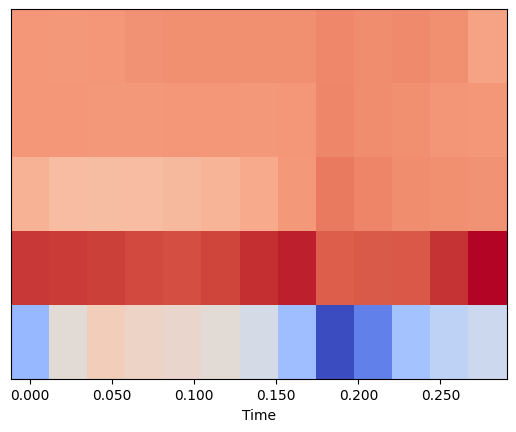

In [16]:
AI_apple01_data, AI_apple01_sr = librosa.load("AI_Test/Apple/ElevenLabs_2024-06-11T20_09_45_Alice_pre_s50_sb75_se0_b_m2.wav")
AI_apple_01_mfcc_features = mfcc(y = AI_apple01_data, sr = AI_apple01_sr, n_mfcc = 5)
AI_apple_01_mfcc_features = AI_apple_01_mfcc_features[:,:13]
librosa.display.specshow(AI_apple_01_mfcc_features, sr=AI_apple01_sr, x_axis='time')


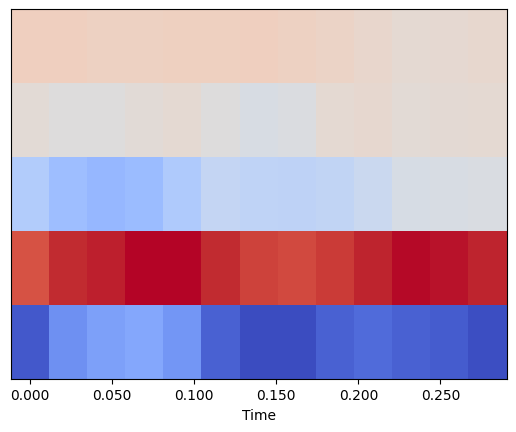

In [15]:
Training_apple, Training_apple_sr = librosa.load("audio/apple/apple01.wav")
Training_apple_mfcc_features = mfcc(y = Training_apple, sr = Training_apple_sr, n_mfcc = 5)
Training_apple_mfcc_features = Training_apple_mfcc_features[:,:13]
librosa.display.specshow(Training_apple_mfcc_features, sr= Training_apple_sr, x_axis='time')

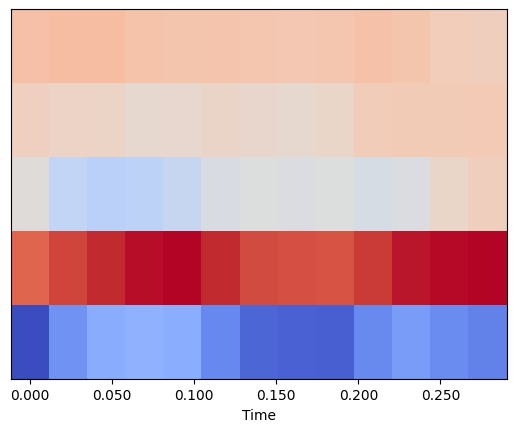

In [12]:
Training_apple1, Training_apple1_sr = librosa.load("audio/apple/apple02.wav")
Training_apple1_mfcc_features = mfcc(y = Training_apple1, sr = Training_apple1_sr, n_mfcc = 5)
Training_apple1_mfcc_features = Training_apple1_mfcc_features[:,:13]
librosa.display.specshow(Training_apple1_mfcc_features, sr=Training_apple1_sr, x_axis='time')

In [17]:
# Getting Frobenius Norm between the 2 MFCC file variations, as well as themselves
ai_vs_training = np.linalg.norm(AI_apple_mfcc_features - Training_apple_mfcc_features, 'fro')
ai_vs_ai = np.linalg.norm(AI_apple_01_mfcc_features - AI_apple_mfcc_features, 'fro')
training_vs_training = np.linalg.norm(Training_apple_mfcc_features - Training_apple1_mfcc_features, 'fro')

print("AI vs Training data: " + str(ai_vs_training))
print("AI vs AI data: " + str(ai_vs_ai))
print("Training vs Training data: " + str(training_vs_training))

AI vs Training data: 661.0706
AI vs AI data: 619.79285
Training vs Training data: 198.03229


Time Intervals (X-Axis):
The x-axis starts from 0 and goes up a bit past 0.25, which represents 0.25 seconds of audio. 

Frequency Bands (Y-Axis):
The y-axis represents different frequency bands on the Mel scale. Lower bands (near the bottom) correspond to lower frequencies, and higher bands correspond to higher frequencies.


Impressionistically, the original testing files generally had a much lower in the lower frequency bands -- as marked by the pedominant blue at the bottom of the y axis, where as the AI generated testing file had a much higher amplitude in the higher frequency bands, indicated by the red and orange at higher y axis. And I believe it is these main differences within the MFCCs that has lead to my models unable to predict which is being pronounced correctly.


Evidently, the difference between one training dataset to the other is relatively small, but the largest when compared to its AI counterpart. What was interesting to observe as that there was a large discrepancy between two AI files -- to which I believe could be attributed to the difference in the speaker's perceived gender. I have included the two media player of the two files below: (Adam has a much faster, and deeper pitched pronounciation vs Alice's higher, and faster pronounciation)

In [ ]:
ipd.Audio("AI_Test/Apple/ElevenLabs_2024-06-11T20_09_42_Adam_pre_s50_sb75_se0_b_m2.wav")

In [ ]:
ipd.Audio("AI_Test/Apple/ElevenLabs_2024-06-11T20_09_45_Alice_pre_s50_sb75_se0_b_m2.wav")

### 5. Concluding Thoughts

This project definitely revealed a lot more information/lessons than I originally thought: 

The process of implementing a sucessfully working HMM was already very timeconsuming -- while I have individual experiences working witht he libraries used in this project, this is the first time I combined them together into working them as into a project of this magnitude. On top of this, finetuning the model with the number of states, figuring out how many MFCCs to include also required a lot of effort and quite a bit of consultation with online sources(Existing Research, Quora and Google Gemini). Testing my models on AI generated data has also definitely revealed the complex relations between MFCCs as well as the speaker's voice properties: Prosody, accent, gender all had played in a role in how it would affect MFCCs as they generate and gets fed into the machine

#### 5.1 Citations
Poorjam, A.H. (2018). Re: Why we take only 12-13 MFCC coefficients in feature extraction?. 
https://www.researchgate.net/post/Why_we_take_only_12-13_MFCC_coefficients_in_feature_extraction/5b0fd2b7cbdfd4b7b60e9431/citation/download.

"HMM Speech Recognition." Google Code Archive, 16 Dec. 2010, https://code.google.com/archive/p/hmm-speech-recognition/downloads.

Porter, M, "Speech Recognition", 2017, GitHub 
https://github.com/fractalbass/speech_recognition

Joshi, P. (2016). Python Machine Learning Cookbook: 100 recipes that teach you how to perform various machine learning tasks in the real world. http://cds.cern.ch/record/2205005

Singh, P. P., & Rani, P. (2014). An approach to extract feature using MFCC. Journal Name, Volume(Issue), 21-25.  https://doi.org/10.9790/3021-04812125

Normalized Nerd! (2021). Markov Chains Clearly Explains! [YouTube playlist]. YouTube. https://www.youtube.com/playlist?list=PLM8wYQRetTxBkdvBtz-gw8b9lcVkdXQKV